## The original CNN model as taken from online source

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import argparse
import os
import random
import signal
import sys
import uuid
from collections import deque

import cv2
import gym
import gym_donkeycar
import numpy as np
import tensorflow as tf
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt # debug
# logging
# from stable_baselines import logger
# from stable_baselines.common import explained_variance, tf_util, TensorboardWriter
# from stable_baselines.common.tf_util import mse, total_episode_reward_logger
import math
import datetime
# from imageprocess import detect_edge
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames

In [15]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
    def build_model(self):
        model = Sequential()
        model.add(
            Conv2D(24, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows, img_cols, img_channels))
        )  # 80*80*4
        model.add(Activation("relu"))
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
        model.add(Activation("relu"))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))

        # 15 categorical bins for Steering angles
        model.add(Dense(15, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)

        return model

In [16]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()

In [17]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 40, 40, 24)        2424      
_________________________________________________________________
activation_24 (Activation)   (None, 40, 40, 24)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 32)        19232     
_________________________________________________________________
activation_25 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 64)         

## Research on a model of CNN to use in tandem with lane detection
https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [25]:
model = [0] * 8
j=4

model[j] = Sequential()

model[j].add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(80,80,4)))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))

model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))
model[j].add(Dense(15, activation='softmax'))

model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [26]:
model[j].summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 78, 78, 32)        1184      
_________________________________________________________________
batch_normalization_10 (Batc (None, 78, 78, 32)        128       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 76, 76, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 38, 38, 32)        25632     
_________________________________________________________________
batch_normalization_12 (Batc (None, 38, 38, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 38, 32)       

## Build my own CNN

In [45]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
    def build_model(self):
        model = Sequential()
        model.add(
            Conv2D(16, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows, img_cols, img_channels))
        )  # 80*80*4
        model.add(Activation("relu"))
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
        model.add(Activation("relu"))
        
        model.add(layers.GlobalAveragePooling2D()) # replace the CNN model with a custom one
        
        model.add(Dense(128))
        model.add(Activation("relu"))

        # 15 categorical bins for Steering angles
        model.add(Dense(15, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)

        return model

In [46]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 40, 40, 16)        1616      
_________________________________________________________________
activation_62 (Activation)   (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 20, 20, 32)        12832     
_________________________________________________________________
activation_63 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
activation_64 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 5, 5, 128)       

## Edit 2 to CNN: when images are stacked vertically instead of stacking in the color channel

In [3]:
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames

In [12]:
499967

499967

In [82]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
        self.action_size = 15
        self.color_channels=1
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(16, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows*img_channels, img_cols, color_channels), activation='relu'))  # 80*80*4
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same", activation='relu'))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", activation='relu'))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation='relu'))
        model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation='relu'))

        model.add(GlobalAveragePooling2D()) # replace the CNN model with a custom one

        model.add(Dense(128, activation='relu'))

        # 15 categorical bins for Steering angles
        model.add(Dense(self.action_size, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)
        
        return model

In [83]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 160, 40, 16)       416       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 80, 20, 32)        12832     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 40, 10, 64)        51264     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 20, 5, 128)        73856     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 20, 5, 256)        295168    
_________________________________________________________________
global_average_pooling2d_10  (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)             

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

In [54]:
next_obs = cv2.imread("images/0_cam-image_array_.jpg")
x_t = next_obs[:, :, 0]
x_t.shape

(120, 160)

In [69]:
x_t = cv2.resize(x_t, (80, 80))

In [70]:
img_rows, img_col = x_t.shape

In [71]:
img_channels = 4
s_t = np.vstack((x_t,)*img_channels) # 4*80*80
s_t.shape

(320, 80)

In [72]:
s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], color_channels)  # 1*320*80*1
s_t.shape

(1, 320, 80, 1)

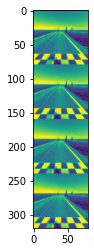

In [74]:
plt.imshow(s_t[0])

In [75]:
next_obs = cv2.imread("images/1283_cam-image_array_.jpg")
x_t1 = next_obs[:, :, 0]
x_t1.shape

(120, 160)

In [76]:
x_t1 = cv2.resize(x_t1, (80, 80))

In [77]:
color_channels = 1
x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], color_channels)  # 1x80x80x1

In [78]:
s_t[:, img_rows:, :, :].shape

(1, 240, 80, 1)

In [79]:
s_t1 = np.append(x_t1, s_t[:, img_rows:, :, :], axis=1)  # 1x320x80x4
s_t1.shape

(1, 320, 80, 1)

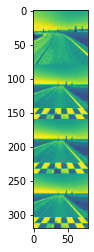

In [80]:
plt.imshow(s_t1[0])

In [84]:
model(s_t1)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[ 0.21673009, -3.4038894 , -1.6912638 ,  1.470401  , -1.1312703 ,
        -0.9440307 ,  3.268939  ,  2.7457528 , -2.42553   ,  1.223944  ,
        -2.5801084 , -0.9476988 ,  0.5892639 ,  2.4082983 ,  2.1118782 ]],
      dtype=float32)>